In [ ]:
import os
import sys
import time
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties
from scipy.stats import chi2_contingency

# 獲取當前工作目錄
current_dir = os.getcwd()
version3_path = os.path.join(current_dir, "TrafficTDApython", "Version3", "tdamapper", "core_old.py")

from sklearn.cluster import AgglomerativeClustering
from tdamapper.core_old import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.clustering import FailSafeClustering

from utils.utils_v3 import *
from utils.plots import *
from utils.preprocess import preprocess, process_other, get_unique_ids

try:
    myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
    sns.set(style="whitegrid", font=myfont.get_name())
except Exception as e:
    print(e)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

dataA2 = pd.read_csv("./Data/A2.csv", low_memory=False)
dataA1 = pd.read_csv("./Data/A1.csv")

[Errno 2] No such file or directory: 'C:\\System\\Library\\Fonts\\PingFang.ttc'


In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
    
    # 子類別
    '道路型態子類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要',
    '當事者區分-類別-子類別名稱-車種', '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初',
    '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
]

In [12]:
full_dataA1 = preprocess(dataA1, target='行人', lst=select_lst)
full_dataA2 = preprocess(dataA2, target='行人', lst=select_lst)
mapper_numpy, rbind_data, dummy_data, death, injuried = process_other(full_dataA1, full_dataA2, downsample=False, en=True)

['行動電話或電腦或其他相類功能裝置名稱', '當事者區分-類別-大類別名稱-車種', '車輛撞擊部位大類別名稱-最初']
dummy_data: (3143, 210)


In [ ]:
from kmodes.kmodes import KModes

cost = []
all_results = {}
K = range(1, 6)

for k in K:

    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=10
    )

    labels = km.fit_predict(rbind_data)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

# with open('Version3/Data/CarData/kmode_result.pickle', 'wb') as f:
#     pickle.dump(all_results, f)

plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()
# save all_results
with open('./Data/Kmode/Pass.pkl', 'wb') as f:
    pickle.dump(all_results, f)

In [56]:
print(pd.Series(all_results[2]['labels']).value_counts())
rbind_data['Cluster'] = all_results[2]['labels']

0    2298
1     845
dtype: int64


# MCA

In [ ]:
mca = prince.MCA(
    one_hot=False,
    n_components=12,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)
mca.fit(dummy_data)
lens = mca.transform(dummy_data)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
plot_mca(mca, dummy_data)

In [6]:
grid_search_info = {
    'lens': lens,
    'mapper_numpy': mapper_numpy,
    'rbind_data': rbind_data,
}
with open('../ForMatrix/CalculatedData/Pass.pkl', 'wb') as f:
    pickle.dump(grid_search_info, f)

# Gridsearch

In [ ]:
overlap = 3
interval = 7
detailed_results = []
silhouette_for_intervals = []

mapper_algo = MapperAlgorithm(
    cover=CubicalCover(
        n_intervals=interval,
        overlap_frac=overlap / 10
    ),
    clustering=FailSafeClustering(
        AgglomerativeClustering(
            n_clusters=2,
            linkage='ward'
        )
    ),
    n_jobs=14
)

mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
silhouette_for_intervals.append(mapper_info[1])
result = {
    "overlap": overlap,
    "interval": interval,
    "silhouette": mapper_info[1],
    "mapper_info": mapper_info
}
detailed_results.append(result)
detailed_results_df = pd.DataFrame(detailed_results)

In [9]:
output_file = './Data/Mapper/pass_o3i7.pkl'

with open(output_file, 'rb') as f:
    detailed_results_df = pickle.load(f)
    
# with open(output_file, 'wb') as f:
#     pickle.dump(detailed_results_df, f)

In [ ]:
# read pickle
with open('./ModelPerformance/pass_performance_svc.pkl', 'rb') as f:
    pass_decision_scores = pickle.load(f)

sorted_indices = np.argsort(pass_decision_scores['indices'])
y_decision_sorted = pass_decision_scores['decision_scores'][sorted_indices]
rbind_data['score'] = y_decision_sorted

In [ ]:
# choose = '顯著特徵'
# rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']
choose = 'Significant Features'
rbind_data['Significant Features'] = rbind_data['Road Category - Subcategory'] + ',' + rbind_data['Traffic Signal - Signal Operation'] + ',' + rbind_data["Weather Condition"]

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=87, iterations=100, dim=2,
                                range_lst=[-0.2, 0.2, 0.2, -0.2])
mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info = mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, size=0, threshold=10)
mapper_plotter.plot(choose, avg=False, set_label=True, size=1000, anchor=1.33)

In [ ]:
mapper_plotter.update_colors(choose='天候名稱')
mapper_plotter.plot('天候名稱', set_label=True)

In [ ]:
choose = '死亡'
rbind_data['死亡'] = death

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=87, iterations=100, dim=2,
                                range_lst=[-0.15, 0.15, 0.2, -0.2])
mapper_plot = mapper_plotter.create_mapper_plot(choose, sum_of_data, avg=True)
full_info, label_out = mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, size=0, threshold=0)
mapper_plotter.plot_dens(choose, avg=True, set_label=False, size=100000, minimum_lst=[-0.05, 0.05])

# Polygon

In [ ]:
from shapely.geometry import Point, Polygon

threshold = -0.0328
x_max = 0.25
x_min = -0.25
y_max = 0.25
y_min = -0.25

rectangle1 = Polygon([(threshold, y_min), (x_min, y_min), (x_min, y_max), (threshold, y_max)])
rectangle2 = Polygon([(threshold, y_min), (threshold, y_max), (x_max, y_max), (x_max, y_min)])

th = 2
filtered_full_info = full_info[(full_info['y'] > -th) &
                               (full_info['y'] < th) &
                               (full_info['x'] > -th) &
                               (full_info['x'] < th)]

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
# 繪製矩形區塊
for rect, color, alpha in zip([rectangle1, rectangle2], 
                              ['green', 'blue'], 
                              [0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)
# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [ ]:
plot_labels(label_0, label_1, label_out, title="Label and Outlier Visualization")

In [8]:
rbind_data['死亡'] = death
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_out"],
    [count_0, count_1, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes]
count_1 = [i for i in count_1 if i not in intersection_indexes]
count_out = [i for i in count_out if i not in intersection_indexes]


full_0 = rbind_data.loc[count_0]
full_1 = rbind_data.loc[count_1]
full_out = rbind_data.loc[count_out]
overlap_data = rbind_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_out.shape[0] + overlap_data.shape[0])
print(rbind_data.shape[0])

3143
3143


In [9]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

0    529
1     11
Name: 死亡, dtype: int64
0    2373
1      32
2       1
Name: 死亡, dtype: int64
0    163
1     13
Name: 死亡, dtype: int64
0    20
1     1
Name: 死亡, dtype: int64


In [10]:
full_info.to_csv('./Data/PassData/full_info.csv', index=False)
full_0.to_csv('./Data/PassData/full_0.csv', index=False)
full_1.to_csv('./Data/PassData/full_1.csv', index=False)
full_out.to_csv('./Data/PassData/full_out.csv', index=False)
overlap_data.to_csv('./Data/PassData/overlap_data.csv', index=False)

# 統計分析

In [ ]:
chi_lst = [
    'Weather Condition', 'Lighting Condition', 'Road Category - First Party - Name', 'Speed Limit - First Party', 'Road Surface Condition - Pavement Type',
    'Road Surface Condition - Surface State', 'Road Surface Condition - Surface Defects', 'Road Obstruction - Obstacle Type', 'Road Obstruction - Visibility Quality', 'Road Obstruction - Sight Distance',
    'Traffic Signal - Signal Type', 'Traffic Signal - Signal Operation', 'Lane Division Facility - Between Fast and General Lanes',
    'Lane Division Facility - Between Fast and Slow Lanes', 'Lane Division Facility - Road Edge Line', 'Party Attribute - Gender', 'Party Age at Accident',
    'Protective Equipment', 'Hit and Run - Yes or No', 'Road Category - Major Category',
    'Accident Location - Major Category', 'Lane Division Facility - Major Category', 'Accident Type and Form - Major Category',
    'Vehicle Impact Area - Other',
]

results = []
rbind_data['death'] = death.apply(lambda x: 1 if x >= 1 else 0)
rbind_data['受傷'] = injuried

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 3.3))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('Chi-square Value')
plt.ylabel('Feature')
plt.title('Significant Features (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

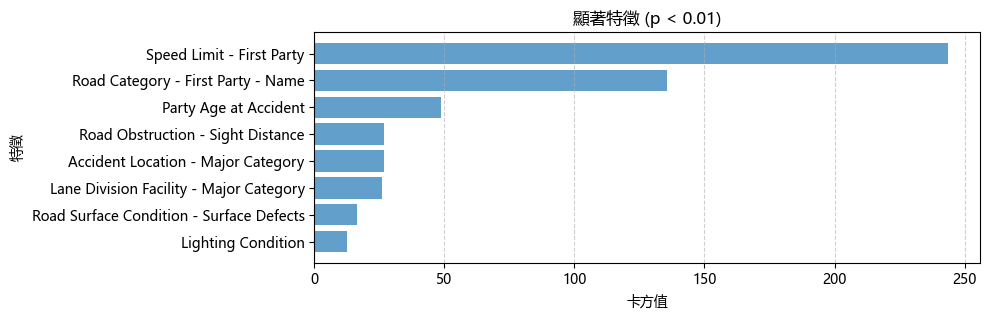

In [ ]:
chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱',
    '車輛撞擊部位大類別名稱-其他']

results = []
rbind_data['death'] = death.apply(lambda x: 1 if x >= 1 else 0)
rbind_data['受傷'] = injuried

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 3.3))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('卡方值')
plt.ylabel('特徵')
plt.title('顯著特徵 (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 道路類別-第1當事者-名稱

In [44]:
plot_column = '道路類別-第1當事者-名稱'

data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(),
    "正常號誌、直路": full_1[plot_column].value_counts(),
    "無號誌、三岔路": full_2[plot_column].value_counts(),
    "無號誌、直路": full_3[plot_column].value_counts(),
    "覆蓋值": overlap_data[plot_column].value_counts(),
    "離群值": full_out[plot_column].value_counts(),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
道路類別-第1當事者-名稱,,,,,,
市區道路,442.0,96.0,254.0,1472.0,127.0,85.0
村里道路,41.0,6.0,23.0,201.0,33.0,28.0
其他,17.0,6.0,14.0,50.0,3.0,17.0
縣道,10.0,3.0,9.0,34.0,6.0,5.0
省道,8.0,2.0,4.0,28.0,1.0,11.0
鄉道,5.0,1.0,2.0,27.0,4.0,1.0
國道,0.0,0.0,0.0,0.0,0.0,11.0
專用道路,0.0,0.0,0.0,8.0,0.0,0.0
快速(公)道,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(normalize=True),
    "正常號誌、直路": full_1[plot_column].value_counts(normalize=True),
    "無號誌、三岔路": full_2[plot_column].value_counts(normalize=True),
    "無號誌、直路": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)

categories_to_merge = ["縣道", "省道", "鄉道", "國道", "專用道路", "快速(公)道"]
comparison_df.loc["其他"] += comparison_df.loc[categories_to_merge].sum()
comparison_df = comparison_df.drop(index=categories_to_merge)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
道路類別-第1當事者-名稱,,,,,,
市區道路,0.845124,0.842105,0.830065,0.808791,0.729885,0.534591
村里道路,0.078394,0.052632,0.075163,0.110440,0.189655,0.176101
其他,0.076482,0.105263,0.094771,0.080769,0.080460,0.289308


# 嚴重程度

In [47]:
def get_severity(input_data):
    """
    更新嚴重程度欄位邏輯：
    - 死亡 > 0 時，設定為 2
    - 死亡 = 0 且受傷 = 1 時，設定為 0
    - 死亡 = 0 且受傷 > 1 時，設定為 1
    """
    def severity_logic(row):
        if row['死亡'] > 0:
            return '死亡'
        elif row['死亡'] == 0 and row['受傷'] == 1:
            return '受傷1'
        elif row['死亡'] == 0 and row['受傷'] > 1:
            return '受傷1+'
        else:
            return 0

    input_data['嚴重程度'] = input_data.apply(severity_logic, axis=1)
    return input_data

full_0_s = get_severity(full_0)
full_1_s = get_severity(full_1)
full_2_s = get_severity(full_2)
full_3_s = get_severity(full_3)
full_out_s = get_severity(full_out)
overlap_data_s = get_severity(overlap_data)

In [48]:
plot_column = '嚴重程度'

data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(),
    "正常號誌、直路": full_1[plot_column].value_counts(),
    "無號誌、三岔路": full_2[plot_column].value_counts(),
    "無號誌、直路": full_3[plot_column].value_counts(),
    "覆蓋值": overlap_data[plot_column].value_counts(),
    "離群值": full_out[plot_column].value_counts(),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
嚴重程度,,,,,,
Total,523,114,306,1820,174,159
受傷1,300,68,150,823,87,87
受傷1+,211,45,154,964,86,63
死亡,12,1,2,33,1,9


In [49]:
data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(normalize=True),
    "正常號誌、直路": full_1[plot_column].value_counts(normalize=True),
    "無號誌、三岔路": full_2[plot_column].value_counts(normalize=True),
    "無號誌、直路": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df.loc["Total"] = total_row
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
嚴重程度,,,,,,
Total,523.000000,114.000000,306.000000,1820.000000,174.000000,159.000000
受傷1,0.573614,0.596491,0.490196,0.452198,0.500000,0.547170
受傷1+,0.403442,0.394737,0.503268,0.529670,0.494253,0.396226
死亡,0.022945,0.008772,0.006536,0.018132,0.005747,0.056604


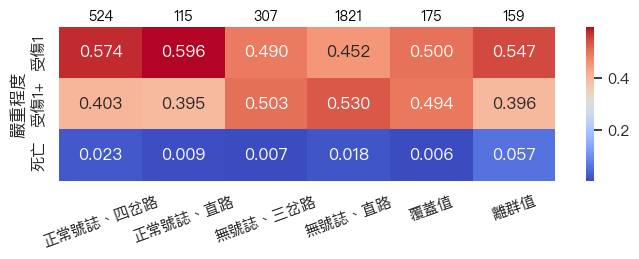

In [50]:
# 重新計算 Total 行，並添加到 DataFrame
comparison_df.loc["Total"] = comparison_df.sum(axis=0)

# 獲取 Total 行數據
total_row = comparison_df.loc["Total"]

# 提取僅包含數值的列，並移除 Total 行
numeric_df = comparison_df.select_dtypes(include=[float, int]).drop("Total")

# 繪製 heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(numeric_df.tail(3), annot=True, cmap='coolwarm', fmt=".3f")

# 添加總數標註在每個欄位的頂部
for i, total in enumerate(total_row):
    plt.text(i + 0.5, -0.2, f"{int(total)}", ha='center', va='center', fontsize=10, color='black')

# 調整外觀
plt.xticks(rotation=20)
plt.show()
